In [12]:
import matplotlib.pyplot as plt  
import matplotlib.patches as patches  
def plot_bbox(image, data):
   # Create a figure and axes  
    fig, ax = plt.subplots()  
      
    # Display the image  
    ax.imshow(image)  
      
    # Plot each bounding box  
    for bbox, label in zip(data['bboxes'], data['bboxes_labels']):  
        # Unpack the bounding box coordinates  
        x1, y1, x2, y2 = bbox  
        # Create a Rectangle patch  
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')  
        # Add the rectangle to the Axes  
        ax.add_patch(rect)  
        # Annotate the label  
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))  
      
    # Remove the axis ticks and labels  
    ax.axis('off')  
      
    # Show the plot  
    plt.show()  

In [13]:
import requests
import torch
from PIL import Image
from transformers import AutoModelForCausalLM, AutoProcessor

model_id = 'microsoft/Florence-2-base'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).eval()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

def run_example(image, task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    generated_ids = model.generate(
      input_ids=inputs["input_ids"],
      pixel_values=inputs["pixel_values"],
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text, 
        task=task_prompt, 
        image_size=(image.width, image.height)
    )

    return parsed_answer

In [14]:
def crop_to_garment(image, result):
    if 'garment' in result['<OPEN_VOCABULARY_DETECTION>']['bboxes_labels']:
        label_idx = result['<OPEN_VOCABULARY_DETECTION>']['bboxes_labels'].index('garment')
        bbox = result['<OPEN_VOCABULARY_DETECTION>']['bboxes'][label_idx]
        x1, y1, x2, y2 = bbox
        return image.crop((x1, y1, x2, y2))
    else:
        return None
    
def is_close_up(image, result):
    if 'garment' in result['<OPEN_VOCABULARY_DETECTION>']['bboxes_labels']:
        img_size = image.size
        bbox = result['<OPEN_VOCABULARY_DETECTION>']['bboxes'][0]
        x1, y1, x2, y2 = bbox
        diff_x = (x2 - x1) / img_size[0]
        diff_y = (y2 - y1) / img_size[1]
        print('bbox_x', bbox[0], bbox[2])
        print('img_size_x', img_size[0])
        print('bbox_y', bbox[1], bbox[3])
        print('img_size_y', img_size[1])
        print('diff_x', diff_x)
        print('diff_y', diff_y)
        return diff_x > 0.95 and diff_y > 0.95
    else:
        return False


{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[210.53500366210938, 304.8000183105469, 638.0009765625, 1253.5999755859375]], 'bboxes_labels': ['garment'], 'polygons': [], 'polygons_labels': []}}


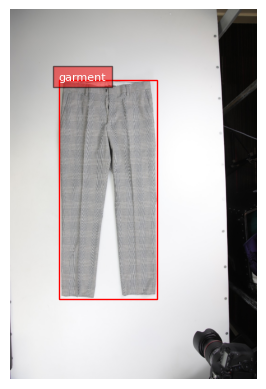

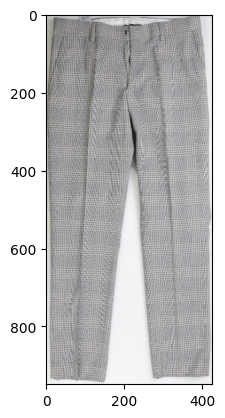

bbox_x 210.53500366210938 638.0009765625
img_size_x 1066
bbox_y 304.8000183105469 1253.5999755859375
img_size_y 1600
diff_x 0.4009999745782276
diff_y 0.5929999732971192
False
{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[193.47900390625, 340.0, 720.0830078125, 1301.5999755859375]], 'bboxes_labels': ['garment'], 'polygons': [], 'polygons_labels': []}}


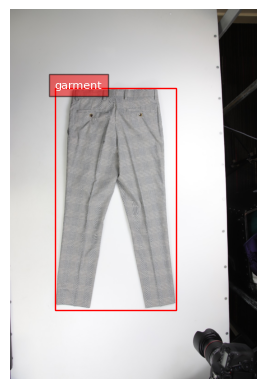

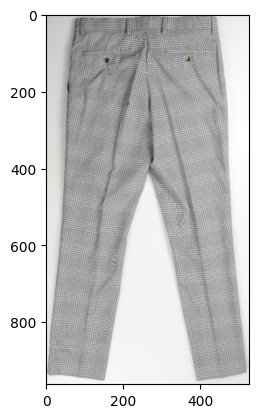

bbox_x 193.47900390625 720.0830078125
img_size_x 1066
bbox_y 340.0 1301.5999755859375
img_size_y 1600
diff_x 0.4940000036643996
diff_y 0.600999984741211
False
{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[0.800000011920929, 0.5329999923706055, 1597.5999755859375, 1064.4010009765625]], 'bboxes_labels': ['garment'], 'polygons': [], 'polygons_labels': []}}


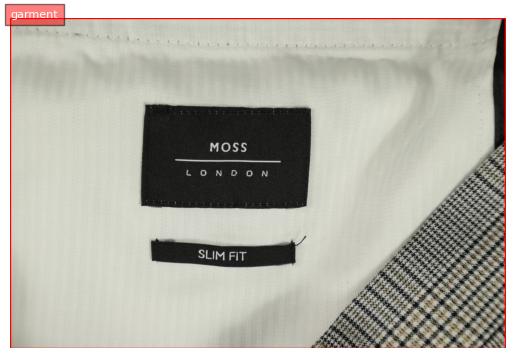

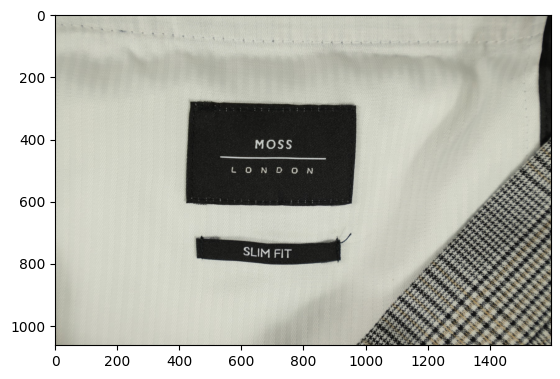

bbox_x 0.800000011920929 1597.5999755859375
img_size_x 1600
bbox_y 0.5329999923706055 1064.4010009765625
img_size_y 1066
diff_x 0.9979999847337604
diff_y 0.9980000009232569
True
{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1.2000000476837158, 0.800000011920929, 2396.400146484375, 1597.5999755859375]], 'bboxes_labels': ['garment'], 'polygons': [], 'polygons_labels': []}}


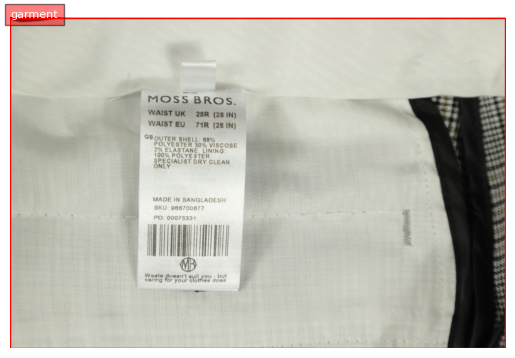

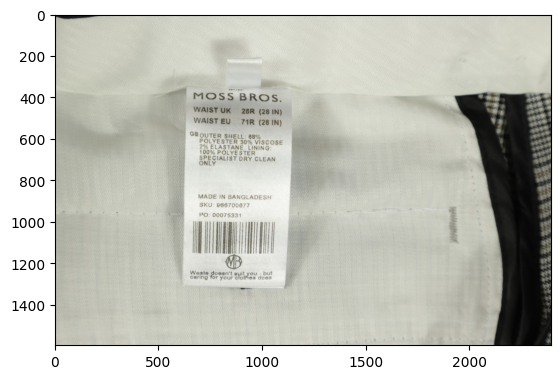

bbox_x 1.2000000476837158 2396.400146484375
img_size_x 2400
bbox_y 0.800000011920929 1597.5999755859375
img_size_y 1600
diff_x 0.998000061015288
diff_y 0.9979999847337604
True


In [15]:
image_paths = [
    "/Users/somogyijanos/Repos/somogyijanos/smartrobe/test-images/01/2025_08_2009_40_370037.JPG",
    "/Users/somogyijanos/Repos/somogyijanos/smartrobe/test-images/01/2025_08_2009_40_490038.JPG",
    "/Users/somogyijanos/Repos/somogyijanos/smartrobe/test-images/01/2025_08_2009_41_010079.JPG",
    "/Users/somogyijanos/Repos/somogyijanos/smartrobe/test-images/01/2025_08_2009_41_120080.JPG"
]

for image_path in image_paths:

    image = Image.open(image_path)
    task_prompt = '<OPEN_VOCABULARY_DETECTION>'
    results = run_example(image, task_prompt, text_input="garment")
    print(results)

    plot_bbox(image, results['<OPEN_VOCABULARY_DETECTION>'])

    cropped_image = crop_to_garment(image, results)
    if cropped_image is not None:
        plt.imshow(cropped_image)
        plt.show()

    print(is_close_up(image, results))
